In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from skimage.feature import SIFT, match_descriptors
from skimage.color import rgb2gray

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

In [4]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [5]:
# Load and preprocess the images
def load_and_preprocess_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    return image

# Convert to image to grayscale
def convert_to_grayscale(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    gray_images = gray_images.astype(np.uint8)
    return gray_images

In [6]:
# Extract Keypoint Features and Descriptors
def detect_and_extract_keypoints(images):
    # Initialise SIFT 
    detector_and_extractor = SIFT(upsampling=2, 
                              n_octaves=15, 
                              n_scales=10, 
                              sigma_min=1.2, 
                              sigma_in=0.5, 
                              c_dog=0.01, 
                              c_edge=20, 
                              n_bins=36, 
                              lambda_ori=1.5, 
                              c_max=0.8, 
                              lambda_descr=6, 
                              n_hist=4, 
                              n_ori=8
                             )

    keypoint_descriptors = []
    keypoint_features = []
    keypoint_pixels = []

    for image in images:
        # Detect and extract keypoint features and descriptors
        detector_and_extractor.detect_and_extract(image)
        key_features = detector_and_extractor.keypoints
        key_descriptors = detector_and_extractor.descriptors

        if len(key_features) > 0:
            key_pixels = []

            for point in key_features:
                key_pixel = image[point[0], point[1]]
                key_pixel = key_pixel/255
                key_pixels.append(key_pixel)
        
            keypoint_pixels.append(key_pixels)
            keypoint_descriptors.append(key_descriptors)
            keypoint_features.append(key_features)

    # Setting the minimum number of features detected in an image
    min_feature_vec_len = 103

    # Slicing all the features, descriptors and pixels to the same length
    sliced_keypoint_feactures = np.array([feat_vec[:min_feature_vec_len] for feat_vec in keypoint_features])
    sliced_keypoint_descriptor = np.array([feat_vec[:min_feature_vec_len] for feat_vec in keypoint_descriptors])
    sliced_keypoint_pixels = np.array([feat_vec[:min_feature_vec_len] for feat_vec in keypoint_pixels])
    return sliced_keypoint_feactures, sliced_keypoint_descriptor, sliced_keypoint_pixels

# Flatten the feature vectors
def flatten_images(image_dataset):
    flattened_images = []

    for image in image_dataset:
        image = image/255
        flat_image = np.ravel(image)
        flattened_images.append(flat_image)
        
    return np.array(flattened_images)



In [7]:
# Load data from the generators
train_images = np.array([load_and_preprocess_image(train_generator.filepaths[i]) for i in range(len(train_generator.filenames))])
valid_images = np.array([load_and_preprocess_image(valid_generator.filepaths[j]) for j in range(len(valid_generator.filenames))])
test_images = np.array([load_and_preprocess_image(test_generator.filepaths[k]) for k in range(len(test_generator.filenames))])

# Convert to grayscale
train_gray_images = convert_to_grayscale(train_images)
valid_gray_images = convert_to_grayscale(valid_images)
test_gray_images = convert_to_grayscale(test_images)

# Extract Keypoint Feature Pixels
train_keypoint_pixels = detect_and_extract_keypoints(train_gray_images)
valid_keypoint_pixels = detect_and_extract_keypoints(valid_gray_images)
test_keypoint_pixels = detect_and_extract_keypoints(test_gray_images)

# Flatten the descriptor files
train_flat_descriptors = flatten_images(train_keypoint_pixels[1])
val_flat_descriptors = flatten_images(valid_keypoint_pixels[1])
test_flat_descriptors = flatten_images(test_keypoint_pixels[1])

# Create the Feature vector
flattened_train_images = np.hstack((train_flat_descriptors, train_keypoint_pixels[2]))
flattened_validation_images = np.hstack((val_flat_descriptors, valid_keypoint_pixels[2]))
flattened_test_images = np.hstack((test_flat_descriptors, test_keypoint_pixels[2]))

# # Convert labels to arrays and one-hot encode
# train_labels = to_categorical(train_generator.labels, num_classes=4)
# valid_labels = to_categorical(valid_generator.labels, num_classes=4)
# test_labels = to_categorical(test_generator.labels, num_classes=4)


In [10]:
train_labels = np.array(train_generator.labels)
valid_labels = np.array(valid_generator.labels)
test_labels = np.array(test_generator.labels)

In [11]:
print(f'train image and label vector length: {len(train_labels)}, {len(flattened_train_images)}')
print(f'validation image and label vector length: {len(valid_labels)}, {len(flattened_validation_images)}')
print(f'test image and label vector length: {len(test_labels)}, {len(flattened_test_images)}')

train image and label vector length: 5138, 5138
validation image and label vector length: 1285, 1285
test image and label vector length: 1606, 1606


# Linear Discriminant Analysis on Keyppoint Features and Descriptors

In [13]:
# HyperParameter Tuning

param_grid = {'lda__solver': ['svd'], 
              'lda__n_components': [1,2,3,4]} 

lda_pipe = Pipeline([
    ('standardscaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

lda_grid_search = GridSearchCV(lda_pipe, param_grid, cv = 5)
lda_grid_search.fit(flattened_train_images, train_labels)

print("Best parameter (CV score=%0.3f):" % lda_grid_search.best_score_)
print(lda_grid_search.best_params_)

Best parameter (CV score=0.331):
{'lda__n_components': 1, 'lda__solver': 'svd'}


In [18]:
# Linear Discriminant Analysis

lda_classifier_svd = LinearDiscriminantAnalysis(solver = 'svd')
lda_classifier_svd.fit(flattened_train_images, train_labels)

LinearDiscriminantAnalysis()

Validation Average accuracy: 0.2933852140077821


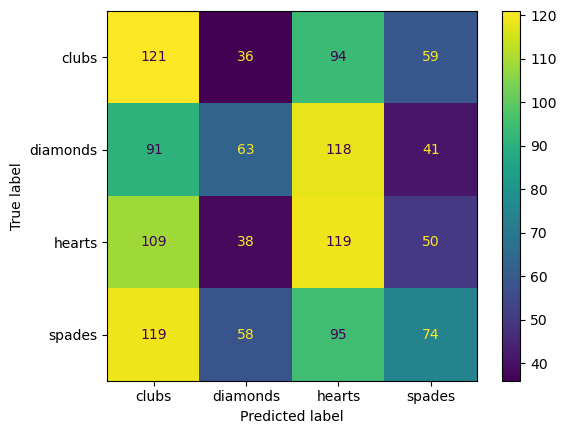

In [19]:
class_names = ['clubs', 'diamonds', 'hearts', 'spades']

# Evaluate the results
lda_val_svd = lda_classifier_svd.score(flattened_validation_images, valid_labels)
print(f'Validation Average accuracy: {lda_val_svd}')

# Predicting labels of validation data
lda_val_predict = lda_classifier_svd.predict(flattened_validation_images)

# Generating the confusion matrix
lda_val_confusion_matrix = confusion_matrix(valid_labels, lda_val_predict)

# Displaying the confusion matrix for the validation dataset
lda_val_display_matrix = ConfusionMatrixDisplay(confusion_matrix = lda_val_confusion_matrix,
                                      display_labels = class_names)

lda_val_display_matrix.plot()
plt.show()

Test Average accuracy: 0.29140722291407223


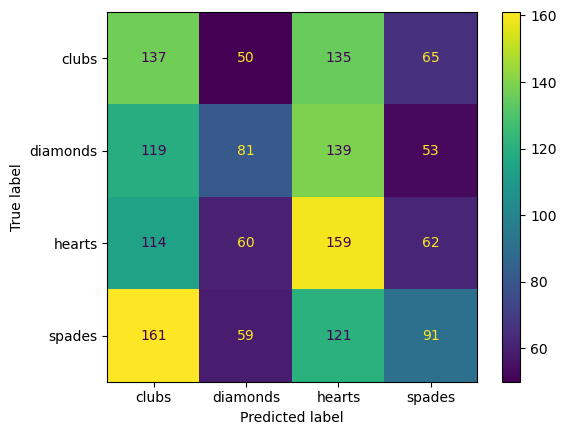

In [20]:
# Evaluate the results
lda_test_svd = lda_classifier_svd.score(flattened_test_images, test_labels)
print(f'Test Average accuracy: {lda_test_svd}')

# Predicting labels of test data
lda_test_predict = lda_classifier_svd.predict(flattened_test_images)

# Generating the confusion matrix for the test dataset
lda_test_confusion_matrix = confusion_matrix(test_labels, lda_test_predict)

# Displaying the confusion matrix for the test dataset
lda_test_display_matrix = ConfusionMatrixDisplay(confusion_matrix = lda_test_confusion_matrix,
                                      display_labels = class_names)

lda_test_display_matrix.plot()
plt.show()